<a href="https://colab.research.google.com/github/ishitaka-code/my_PyPortfolioOpt/blob/master/%E3%83%9D%E3%83%BC%E3%83%88%E3%83%95%E3%82%A9%E3%83%AA%E3%82%AA%E6%9C%80%E9%81%A9%E5%8C%96_PyPortfolioOpt_(emaxis).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[PyPortfolioOpt](https://pyportfolioopt.readthedocs.io/en/latest/index.html#)を使って資産配分の最適化．（使用データ：[https://emaxis.jp](https://emaxis.jp)）

In [ ]:
#### 必要なパッケージのインストール
%%capture
!pip install PyPortfolioOpt
!pip install japanize_matplotlib

In [ ]:
#### emaxis.csvのダウンロード
import os
if os.path.isfile('emaxis.csv'):
    os.remove('emaxis.csv')
import urllib.request
url = "https://emaxis.jp/web/fundCsv.php?setCd="
urllib.request.urlretrieve(url, 'emaxis.csv');

In [ ]:
# -*- coding:utf-8 -*-
import plotly.offline
import plotly.graph_objects as go
# Google Colab. やJupyter Lab.でプロットするためには，以下を実行する．
import plotly.io as pio
pio.renderers.default = "colab"

import datetime
import os
import japanize_matplotlib #日本語化matplotlib
from matplotlib import pyplot as plt, font_manager, rcParams
from IPython.display import display
import csv
from pathlib import Path
import numpy as np
import pandas as pd
%matplotlib inline
pd.options.display.precision = 3  # 小数点以下の桁数設定
font_manager._rebuild()
# rcParams['font.family'] = 'sans-serif'
# rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao',
#                                'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']
# rcParams["figure.dpi"] = 500
plt.rcParams["font.size"] = 14
# 目盛り線の向き、内側"in"か外側"out"かその両方"inout"か
plt.rcParams["xtick.direction"] = "in"
# 目盛り線の向き、内側"in"か外側"out"かその両方"inout"か
plt.rcParams["ytick.direction"] = "in"

CurrDir = Path.cwd()
csvdataDF = pd.read_csv("emaxis.csv", encoding="cp932",
                        low_memory=False, skiprows=0, header=None)
# ヘッダー名を用意（ファンド名を省略）
HeaderNameDF = csvdataDF.iloc[0].dropna()  # 'NaN'を削除
HeaderNameDF_new = HeaderNameDF.replace('ｅＭＡＸＩＳ (.*)', r'\1', regex=True)
HeaderNameDF_new = HeaderNameDF_new.replace(
    '(.*)インデックス(.*)', r'\1\2', regex=True)
# print(HeaderNameDF_new)
# インデックス名を用意
IndexNameDF = csvdataDF.iloc[2:, 0]
IndexNameDF = IndexNameDF.astype('datetime64')
# print(IndexNameDF.dtypes)
# データ部分を用意．各インデックスの「基準価額（分配金再投資）」を抽出
Data_i = [i*5+2 for i in range(len(HeaderNameDF))]
DataDF = csvdataDF.iloc[2:, Data_i]
DataDF = DataDF.astype('float64')
# ヘッダーとインデックスを指定
DataDF.columns = HeaderNameDF_new
DataDF.columns.name = "Fund"
DataDF.index = IndexNameDF
DataDF.index.name = 'Date'
# ====== 日付選択
# DataDF = DataDF.loc['2011/11':]
DataDF = DataDF.loc['2010':]
# DataDF = DataDF.loc['2012':]
# DataDF = DataDF.loc['2019':]
DataDF = DataDF.dropna(how='any', axis=1)  # 指定期間のすべてのデータが有るインデックスのみ採用
# ====== アセット・アロケーションを自作
Balance4DF = pd.DataFrame(
    (DataDF.loc[:, 'ＴＯＰＩＸ'] + DataDF.loc[:, '国内債券']
     + DataDF.loc[:, '先進国株式'] + DataDF.loc[:, '先進国債券'])/4,
    columns=['4資産均等'])
Balance6DF = pd.DataFrame(
    (DataDF.loc[:, 'ＴＯＰＩＸ'] + DataDF.loc[:, '国内債券'] + DataDF.loc[:, '国内リート']
     + DataDF.loc[:, '先進国株式'] + DataDF.loc[:, '先進国債券'] + DataDF.loc[:, '先進国リート'])/6,
    columns=['6資産均等'])
DataDF = pd.concat([DataDF, Balance4DF, Balance6DF], axis=1)
JStockReitDF = pd.DataFrame(
    (DataDF.loc[:, '日経２２５'] + DataDF.loc[:, '国内リート'])/2,
    columns=['国内株リート2均等'])
StockReit4BalanceDF = pd.DataFrame(
    (25*DataDF.loc[:, 'ＴＯＰＩＸ'] + 25*DataDF.loc[:, '国内リート']
     +25*DataDF.loc[:, '先進国株式'] + 25*DataDF.loc[:, '先進国リート'])/100,
    columns=['国内外株リート4均等'])
StockReit3BalanceDF = pd.DataFrame(
    (33*DataDF.loc[:, 'ＴＯＰＩＸ'] + 33*DataDF.loc[:, '国内リート']+34*DataDF.loc[:, '先進国株式'])/100,
    columns=['国内外株+Jリート3均等'])
DataDF = pd.concat([DataDF, JStockReitDF,StockReit4BalanceDF,StockReit3BalanceDF], axis=1)
StockYamagenDF = pd.DataFrame(
    (40*DataDF.loc[:, 'ＴＯＰＩＸ'] + 60*DataDF.loc[:, '先進国株式'])/100,
    columns=['国内外株式4:6'])
DataDF = pd.concat([DataDF, StockYamagenDF], axis=1)
StockReit3HRPDF = pd.DataFrame(
    (41.227*DataDF.loc[:, 'ＴＯＰＩＸ']+35.585*DataDF.loc[:, '国内リート']
     +23.188*DataDF.loc[:, '先進国株式'])/100,
    columns=['株+Jリート3HRP'])
# myWeight =============================================================================
myWeight1DF = pd.DataFrame(
    ( 12.17 *DataDF.loc[:, 'ＴＯＰＩＸ'] 
     + 19.06 *DataDF.loc[:, '先進国株式']
     # eMAXIS Slim 全世界株式(オール・カントリー)
     + 15.42 *(0.073*DataDF.loc[:, 'ＴＯＰＩＸ']+(0.885-0.073)*DataDF.loc[:, '先進国株式']
               +0.115*DataDF.loc[:, '新興国株式'])
     # ＜購入・換金手数料なし＞ニッセイＪリートインデックスファンド
     + 7.46 *DataDF.loc[:, '国内リート']
     # NZAM・ベータ 日本2資産(株式＋REIT)
     + 18.39 *(0.5*DataDF.loc[:, '日経２２５']+0.5*DataDF.loc[:, '国内リート'])
     # ＜購入・換金手数料なし＞ニッセイ・インデックスバランスファンド(6資産均等型)
     + 27. *DataDF.loc[:, '6資産均等'])/100,
    columns=['myWeight'])
# ======================================================================================
myTarget2DF = pd.DataFrame(
    (20 *DataDF.loc[:, '日経２２５']+ 10*DataDF.loc[:, 'ＴＯＰＩＸ'] + 20 *DataDF.loc[:, '国内リート']
     + 50 *DataDF.loc[:, '先進国株式'])/100,
    columns=['myTarget'])
DataDF = pd.concat([DataDF, StockReit3HRPDF, myWeight1DF,myTarget2DF], axis=1)
r = 0.2988 # 6資産均等の割合
myTarget3DF = pd.DataFrame(
    ( (1-r) *DataDF.loc[:, 'myTarget'] + r *DataDF.loc[:, '6資産均等']),
    columns=['myTarget+6均等'])
DataDF = pd.concat([DataDF, myTarget3DF], axis=1)
# testTargetDF = pd.DataFrame(
#     ( 53 *DataDF.loc[:, '全世界株式'] 
#      + 47 *(0.5*DataDF.loc[:, '日経２２５']+0.5*DataDF.loc[:, '国内リート']))/100,
#     columns=['testTarget'])
# DataDF = pd.concat([DataDF, testTargetDF], axis=1)



# DataDF['日経２２５レバ'] = DataDF.loc[:, '日経２２５'].shift()* (1+ 3* DataDF.loc[:, '日経２２５'].pct_change())
# DataDF['日本株債権レババラ'] = (0.9* DataDF.loc[:, '日経２２５'] + 2.7* DataDF.loc[:, '国内債券'])
# DataDF['先進国株債権レババラ'] = (0.9* DataDF.loc[:, '先進国株式'] + 2.7* DataDF.loc[:, '先進国債券'])


# 期間初日で割って指数化
DataDF = ( DataDF / DataDF.iloc[0] )
display(DataDF.head(3))

# DataDFplot = DataDF.plot(figsize=(12,5),grid=True,logy=False,
#                          title='ｅＭＡＸＩＳ：基準価額（分配金再投資）')
# DataDFplot = DataDFplot.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

# print("\nPlotly version: ", plotly.__version__)
# plotly.offline.init_notebook_mode()
fig = go.Figure()
n = 0
for column_name, item in DataDF.iteritems():
    legendname = str(n) + ':' + column_name
    fig.add_trace(go.Scatter(x=DataDF.index, y=item, name=legendname))
    n += 1
fig.update_layout(title_text='ｅＭＡＸＩＳ：基準価額（分配金再投資）',
                  xaxis_rangeslider_visible=True)
fig.show()

,日経２２５,ＴＯＰＩＸ,国内債券,国内リート,先進国株式,先進国債券,先進国リート,新興国株式,4資産均等,6資産均等,国内株リート2均等,国内外株リート4均等,国内外株+Jリート3均等,国内外株式4:6,株+Jリート3HRP,myWeight,myTarget,myTarget+6均等
Date,,,,,,,,,,,,,,,,,,
2010-01-04,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
2010-01-05,1.003,1.004,1.000,1.005,1.012,0.999,0.995,1.016,1.004,1.002,1.004,1.004,1.007,1.009,1.006,1.006,1.008,1.006
2010-01-06,1.007,1.017,0.999,0.997,1.005,0.990,0.992,1.017,1.003,1.000,1.002,1.003,1.006,1.009,1.007,1.004,1.005,1.003


In [ ]:
# DataDF['日経２２５レバ'] = DataDF['日経２２５']
# # display(DataDF['日経２２５'].pct_change())
# # for i, row in enumerate(DataDF['日経２２５レバ']):
# #     DataDF['日経２２５'].pct_change()
# #     print(i, row)

# for index, row in DataDF.iterrows():
#     print(index)

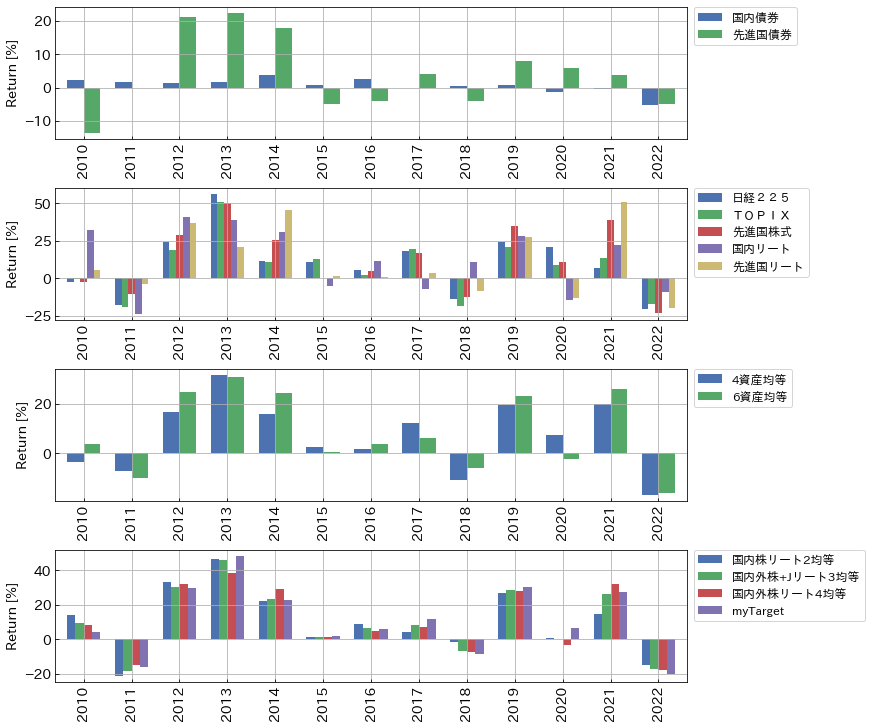

In [ ]:
from pypfopt import expected_returns, risk_models, plotting
YearStrList = DataDF.index.year.drop_duplicates().astype(str)
YearReturn = YearRisk = pd.DataFrame(columns=DataDF.columns)
for year in YearStrList:
    DataDF_i = DataDF.loc[year]
    Return_i = pd.Series(expected_returns.mean_historical_return(DataDF_i)*100, name=year) # 平均リターン
    YearReturn = YearReturn.append(Return_i)

# SMatrix_i = risk_models.CovarianceShrinkage(DataDF_i).ledoit_wolf()  # 収縮した共分散行列（Ledoit-Wolfの方法）．
# Risk_i = pd.DataFrame(np.sqrt(np.diag(SMatrix_i)), index=Return.index)*100  # 標準偏差計算

# import pandas_bokeh
# pandas_bokeh.output_notebook()
# # pandas_bokeh.output_file('bar.html')
# df = pd.DataFrame(YearReturn.loc[:,['日経２２５', 'ＴＯＰＩＸ', '先進国株式','国内リート','先進国リート']])
# df.plot_bokeh(
#     kind="bar",
#     ylabel="リターン [%]",
#     alpha=0.6, figsize=(800,300),
#     )

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 10), constrained_layout = True)
alpha=1
width=0.7
YearReturn.plot(y=[s for s in DataDF.columns if ('債券' in s)], ax=axes[0],
                kind='bar', alpha=alpha, width=width)
if 'バランス（８資産均等型）' in DataDF.columns:
    YearReturn.plot(y=['日経２２５', 'ＴＯＰＩＸ', '先進国株式', '新興国株式', '国内リート', '先進国リート'], ax=axes[1],
                    kind='bar', alpha=alpha, width=width)
    YearReturn.plot(y=['4資産均等', '6資産均等','バランス（８資産均等型）'], ax=axes[2],
                    kind='bar', alpha=alpha, width=width)
else:
    YearReturn.plot(y=['日経２２５', 'ＴＯＰＩＸ', '先進国株式', '国内リート', '先進国リート'], ax=axes[1],
                    kind='bar', alpha=alpha, width=width)
    YearReturn.plot(y=['4資産均等', '6資産均等'], ax=axes[2],
                    kind='bar', alpha=alpha, width=width)
YearReturn.plot(y=['国内株リート2均等', '国内外株+Jリート3均等', '国内外株リート4均等','myTarget'], ax=axes[3],
                kind='bar', alpha=alpha, width=width)
for ax in axes:
    # ax.set_xlabel('日別変化率')
    ax.set_ylabel('Return [%]')
    ax.grid(True)
    ax.legend(fontsize=12, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.show()

In [ ]:
ReturnMax = YearReturn.max().max()
YearReturn.style.background_gradient(axis=None,cmap='seismic',vmin=-ReturnMax,vmax=ReturnMax)

,日経２２５,ＴＯＰＩＸ,国内債券,国内リート,先進国株式,先進国債券,先進国リート,新興国株式,4資産均等,6資産均等,国内株リート2均等,国内外株リート4均等,国内外株+Jリート3均等,国内外株式4:6,株+Jリート3HRP,myWeight,myTarget,myTarget+6均等
2010,-2.809,-0.273,2.171,32.231,-2.537,-13.676,5.415,2.335,-3.513,3.794,14.191,8.404,9.319,-1.641,10.416,5.132,4.281,4.137
2011,-17.800,-19.009,1.668,-24.017,-10.691,-0.155,-3.858,-24.446,-7.361,-10.193,-21.296,-14.804,-18.384,-14.040,-19.351,-15.197,-16.084,-14.347
2012,24.107,18.497,1.505,40.854,29.023,21.137,37.036,28.858,16.934,24.906,33.166,32.025,30.076,24.999,29.614,28.310,29.729,28.246
2013,56.424,50.741,1.748,38.772,50.026,22.397,21.010,12.994,31.942,31.044,46.341,38.672,45.873,50.285,45.550,42.653,48.557,43.343
2014,11.529,11.103,3.835,30.977,25.354,17.981,45.257,15.266,15.741,24.580,22.162,28.857,23.337,20.147,22.454,23.170,22.807,23.293
2015,11.078,12.569,0.641,-5.233,0.128,-4.800,1.414,-14.902,2.391,0.473,1.507,1.296,1.238,4.373,1.902,1.165,1.680,1.345
2016,5.308,2.446,2.573,11.269,4.476,-3.974,0.587,6.721,1.785,3.519,8.606,4.779,6.429,3.733,6.498,5.425,5.993,5.310
2017,18.325,19.410,-0.071,-7.095,16.704,4.124,3.745,30.648,12.133,5.984,4.066,6.968,8.283,17.687,7.689,9.772,11.641,10.106
2018,-13.878,-18.920,0.557,11.128,-12.421,-4.155,-8.730,-20.097,-11.009,-6.198,-1.554,-7.223,-6.740,-14.846,-6.577,-7.980,-8.761,-8.095
2019,24.315,20.519,0.770,28.437,35.118,7.824,27.264,23.170,19.552,23.194,26.613,28.125,28.489,29.841,27.232,27.986,30.272,28.388


No handles with labels found to put in legend.


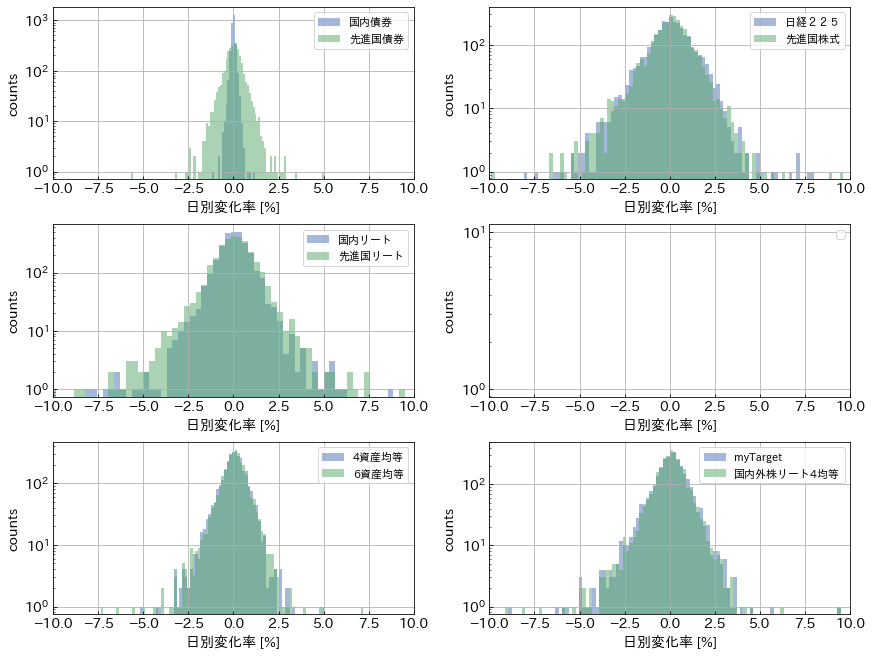

In [ ]:
# ChangeRatioDF = DataDF.loc['2013'].pct_change()*100
ChangeRatioDF = DataDF.pct_change()*100
# print(ChangeRatioDF.max().max())

# def find_bins(observations, width):
#     minimmum = np.min(observations)
#     maximmum = np.max(observations)
#     bound_min = -1.0 * (minimmum % width - minimmum)
#     bound_max = maximmum - maximmum % width + width
#     n = int((bound_max - bound_min) / width) + 1
#     bins = np.linspace(bound_min, bound_max, n)
#     return bins

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 9), constrained_layout = True)
bins=100
alpha=0.5
ChangeRatioDF.plot(y=['国内債券', '先進国債券'], ax=axes[0,0],
                   kind='hist', alpha=alpha, bins=bins);
ChangeRatioDF.plot(y=['日経２２５', '先進国株式'], ax=axes[0,1],
                   kind='hist', alpha=alpha, bins=bins);
ChangeRatioDF.plot(y=['国内リート', '先進国リート'], ax=axes[1,0],
                   kind='hist', alpha=alpha, bins=bins);
# ChangeRatioDF.plot(y=['日経２２５', '新興国株式'], ax=axes[1,1],
#                    kind='hist', alpha=alpha, bins=bins);
ChangeRatioDF.plot(y=['4資産均等', '6資産均等'], ax=axes[2,0],
                   kind='hist', alpha=alpha, bins=bins);
ChangeRatioDF.plot(y=['myTarget', '国内外株リート4均等'], ax=axes[2,1],
                   kind='hist', alpha=alpha, bins=bins);
for axes_i in axes:
    for ax in axes_i:
        ax.set_xlim(-10,10)
        ax.set_yscale('log')
        ax.set_xlabel('日別変化率 [%]')
        ax.set_ylabel('counts')
        ax.grid(True)
        ax.legend(fontsize=11)
plt.show()

,リターン [%],リスク [%],シャープレシオ
日経２２５,9.590,21.049,0.451
ＴＯＰＩＸ,8.143,19.332,0.416
先進国株式,12.085,20.390,0.588
新興国株式,4.640,19.669,0.231
国内リート,11.065,18.841,0.582
先進国リート,10.749,21.020,0.507
4資産均等,7.148,11.541,0.611
6資産均等,8.571,12.381,0.684
国内外株式4:6,10.705,17.879,0.593
国内株リート2均等,10.334,16.749,0.611


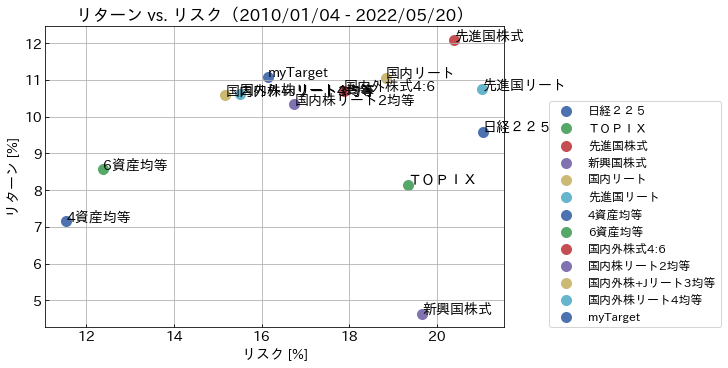

In [ ]:
# ====== 計算アセットを選択
PickDataDF = DataDF
PickAssList = []
# PickAssList.extend([s for s in DataDF.columns if ('債券' in s)])
PickAssList.extend([
    '日経２２５', 'ＴＯＰＩＸ', 
    '先進国株式', '新興国株式', '全世界株式',
    'Ｓｌｉｍ 米国株式（Ｓ＆Ｐ５００）', '米国リート',
    '国内リート','先進国リート',
    'バランス（８資産均等型）',
    '4資産均等','6資産均等',
    '国内外株式4:6',
    '国内株リート2均等',
    '国内外株+Jリート3均等',
    '国内外株リート4均等',
    'myTarget',
    # 'myWeight', 'testTarget'
    ])
PickAssList = sorted(list(set(PickAssList) & set(DataDF.columns)), key=PickAssList.index)
PickDataDF = PickDataDF.loc[:, PickAssList]
# PickDataDF = PickDataDF.iloc[:,[ 0,1,3,4,6,9,11 ]] # 列番号指定

# PickDataDF = PickDataDF.loc[:,[ '国内債券', 'ＴＯＰＩＸ','先進国株式','国内リート' ]]
# PickDataDF = PickDataDF.loc[:,[ '国内株リート2均等', 'ＴＯＰＩＸ', '先進国株式', '6資産均等']]
# PickDataDF = PickDataDF.loc[:,[ '日経２２５', '国内リート' ,'先進国株式']]
# PickDataDF = PickDataDF.loc[:,[ 'ＴＯＰＩＸ', '国内リート' ,'先進国株式']]
# PickDataDF = PickDataDF.loc[:,[ 'ＴＯＰＩＸ', '先進国株式', '国内リート' ,'先進国リート']]
# PickDataDF = PickDataDF.loc[:,~(PickDataDF.columns.str.contains('日経２２５'))] # 除外
PickDataDF = PickDataDF.loc[:,~(PickDataDF.columns.str.contains('バランス（波乗り型）'))] # 除外
# PickDataDF = PickDataDF.loc[:,~(PickDataDF.columns.str.contains('債券'))] # 債券を除外
# PickDataDF = PickDataDF.loc[:,~(PickDataDF.columns.str.contains('新興国'))] # 新興国を除外

# ====== 年率期待リターン算出方法選択
mu = expected_returns.mean_historical_return(PickDataDF) # 平均リターン
expSpan = 5 # 指数的加重用年指定
# mu = expected_returns.ema_historical_return(PickDataDF, span=365*expSpan) # 指数的加重平均リターン（実験的）
# ====== リスク（共分散行列）算出モデル選択．対角成分は分散．
# S = risk_models.sample_cov(PickDataDF) # 教科書的．改良版のCovarianceShrinkageのほうがよい．
S = risk_models.CovarianceShrinkage(PickDataDF).ledoit_wolf()  # 収縮した共分散行列（Ledoit-Wolfの方法）．
# S = risk_models.exp_cov(PickDataDF,span=365*expSpan) # 指数関数的に重み付けされた共分散行列．（実験的）
# S = risk_models.semicovariance(PickDataDF) # 下方リスクのみを推定．半共分散行列．（実験的）
# S = risk_models.min_cov_determinant(PickDataDF) # ノイズ（汚いデータ）に対してロバストな推定．最小共分散行列．
# ====== リスクフリーレート入力
RiskFreeRate = 0.001

sigma = pd.DataFrame(np.sqrt(np.diag(S)), index=mu.index)  # 標準偏差計算
SR = pd.DataFrame([  # シャープレシオ計算
                   (mu.iloc[n]-RiskFreeRate) / sigma.iloc[n] for n in range(len(mu))], index=mu.index)
assetsProDF = pd.concat([mu, sigma, SR], axis=1)*100
performName = ['リターン [%]', 'リスク [%]', 'シャープレシオ']
assetsProDF.columns = performName
assetsProDF[[performName[2]]] *= 1/100
display(assetsProDF.style.bar(subset=['シャープレシオ'], align='mid', color=['#d65f5f', '#5fba7d']))
# assetsProDF.to_clipboard()

# リターン vs リスク プロット
fig, ax = plt.subplots(figsize=(5*2, 5), constrained_layout=True)
# ax.set_aspect('equal')
for row in assetsProDF.itertuples():
    ax.scatter(x=row[2], y=row[1], label=row[0], s=100)
    ax.annotate(row[0], xy=(row[2],row[1]),size=14)
ax.grid(which='both')
ax.legend(bbox_to_anchor=(1.1, 0), loc='lower left', borderaxespad=0, fontsize=12) # 凡例
ax.set_xlabel(performName[1])
ax.set_ylabel(performName[0])
ax.set_title("リターン vs. リスク（"
             +min(DataDF.index).strftime('%Y/%m/%d')+" - "
             +max(DataDF.index).strftime('%Y/%m/%d')+"）")
if 1:
    plt.savefig("ReturnRiskMap.png", dpi=500)
plt.show()

相関係数行列のチェック: True 



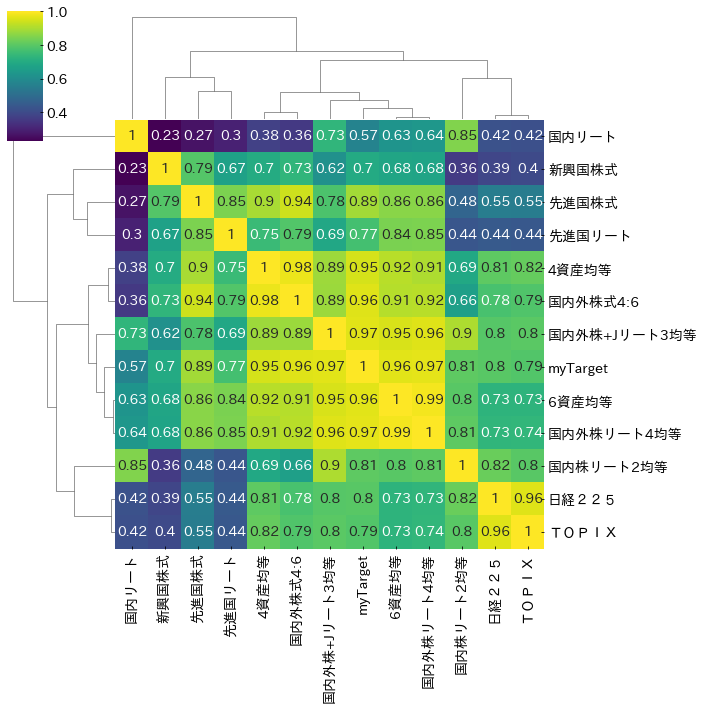

In [ ]:
# 相関係数行列の表示（共分散行列から変換）
print('相関係数行列のチェック:', risk_models._is_positive_semidefinite(S), '\n')
if 0: # 相関係数のプロット
    plotting.plot_covariance(S, plot_correlation=True) 
    plt.show()
CorrMatrix = risk_models.cov_to_corr(S)
# CorrMatrix.to_clipboard()

import seaborn as sns
sns.clustermap(CorrMatrix, cmap='viridis', annot=True)

# CorrMatrix.style.background_gradient(axis=None, cmap='viridis')

## マーコウィッツ最適化

In [ ]:
import ipywidgets as widgets
wiSelect = widgets.SelectMultiple(
    options=mu.index,
    value=['日経２２５', '先進国株式'],
    rows=len(mu.index),
    # description='Fruits',
    # disabled=True
)
display(wiSelect)

SelectMultiple(index=(0, 2), options=('日経２２５', 'ＴＯＰＩＸ', '先進国株式', '新興国株式', '国内リート', '先進国リート', '4資産均等', '6資産均等',…

In [ ]:
OptimizationList = list(wiSelect.value)
mu_opt = mu.loc[OptimizationList]
S_opt = S.loc[OptimizationList, OptimizationList]

,リターン [%],リスク [%],シャープレシオ,先進国株式,国内株リート2均等
シャープレシオ最大化,11.076,15.728,0.698,42.398,57.602
リスク最小化,10.890,15.594,0.692,31.753,68.247


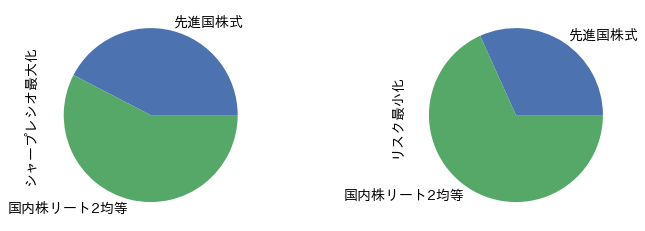

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
# シャープ・レシオ最大化
ef = EfficientFrontier(mu_opt, S_opt, weight_bounds=(0.0, 1.))
WeightsSharpe = ef.max_sharpe(risk_free_rate=RiskFreeRate)
CleanedWeightsSharpe = ef.clean_weights()
PerfSharpe = ef.portfolio_performance(risk_free_rate=RiskFreeRate)
# リスク最小化
ef = EfficientFrontier(mu_opt, S_opt, weight_bounds=(0.0, 1.))
WeightsVola = ef.min_volatility()
CleanedWeightsVola = ef.clean_weights()
PerfVola = ef.portfolio_performance(risk_free_rate=RiskFreeRate)
# weights = ef.efficient_return(target_return=0.05) # リターン制約のもとでのリスク最小化
# weights = ef.efficient_risk(target_volatility=1.) # リスク制約のもとでのシャープ・レシオ最大化
WeightsDF = pd.DataFrame(data=[CleanedWeightsSharpe, CleanedWeightsVola])
PerfDF = pd.DataFrame(data=[PerfSharpe, PerfVola], columns=performName)
ResultDF = pd.concat([PerfDF, WeightsDF], axis=1)*100
ResultDF[[performName[2]]] *= 1/100 
ResultDF.index = ['シャープレシオ最大化', 'リスク最小化']
display(ResultDF)
# ResultDF.to_clipboard()
resultPlot = ResultDF.iloc[:,3:].T.plot.pie(figsize=(12,4), subplots=True, legend=False)

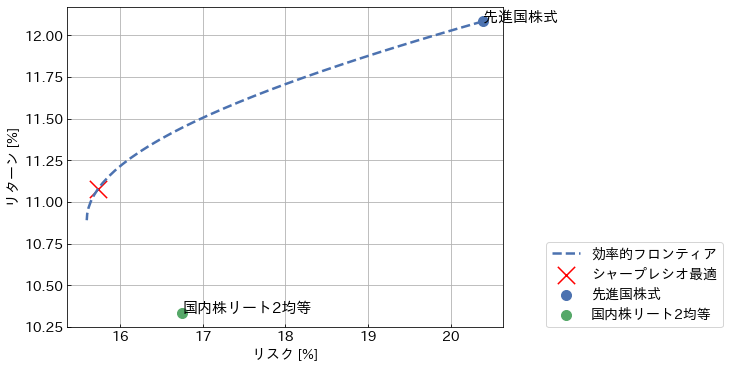

In [ ]:
from pypfopt.cla import CLA
cla = CLA(mu_opt, S_opt, weight_bounds=(0.0, 1.))
frontier_values = cla.efficient_frontier()
FrontierValuesDF = pd.DataFrame(frontier_values).T*100
FrontierValuesDF.columns = ["効率的フロンティア", performName[1], 'weights']
weights = cla.max_sharpe()  # シャープ・レシオ最大化
# weights = cla.min_volatility()# リスク最小化
cleaned_weights = cla.clean_weights()
# display(pd.DataFrame(cleaned_weights,index=["Weights [%]"])*100)
perform_values = cla.portfolio_performance(verbose=False, risk_free_rate=RiskFreeRate)
PerformDF = pd.DataFrame(perform_values).T
PerformDF.loc[0, 0:1] *= 100
PerformDF.columns = performName

# プロット
fig, ax = plt.subplots(figsize=(5*2, 5), constrained_layout=True)
# ax.set_aspect('equal')
ax.plot(FrontierValuesDF[FrontierValuesDF.columns[1]], FrontierValuesDF[FrontierValuesDF.columns[0]],
        label=FrontierValuesDF.columns[0], linewidth=2.5, linestyle='dashed')
ax.scatter(PerformDF.iloc[0, 1], PerformDF.iloc[0, 0],
           label='シャープレシオ最適', marker='x', s=300, c='red')
for row in assetsProDF.loc[OptimizationList].itertuples():
    ax.scatter(x=row[2], y=row[1], label=row[0], s=100)
    ax.annotate(row[0], xy=(row[2], row[1]), size=15)
ax.grid(which='both')
ax.legend(bbox_to_anchor=(1.1, 0), loc='lower left', borderaxespad=0)
ax.set_xlabel(performName[1])
ax.set_ylabel(performName[0])
# ax.set_xlim([0,assetsProDF['リスク [%]'].max()*1.1])
if 0:
    plt.savefig("CLA.png", dpi=500)
plt.show()
# リスクを横軸に書く資産配分をプロット
# weightsList = pd.DataFrame([np.array(row[3]).flatten() for row in FrontierValuesDF.itertuples()],
#                            columns=PickDataDF.columns)
# display(weightsList)
# fig, ax = plt.subplots()
# ax.stackplot(FrontierValuesDF.iloc[:,1],weightsList.iloc[:,0],weightsList.iloc[:,1])
# # ax.legend(loc='upper left')
# plt.show()
# claplot = cla.plot_efficient_frontier(show_assets=False)

### [Hierarchical Risk Parity (HRP): 階層型リスクパリティ](https://pyportfolioopt.readthedocs.io/en/latest/OtherOptimisers.html#hierarchical-risk-parity-hrp)

【おまけ】

MarkowitzのCLAの問題点は，リターンの推定がサンプル期間に対して不安定，共分散行列の逆行列を求めることによる不安定さがあることなどである．HRPは現代の数学（グラフ理論と機械学習技術）を応用して共分散行列に含まれる情報に基づいて分散型ポートフォリオを構築する[1]．銘柄を相関関係で2つに分類．分類を繰り返してツリー構造を作成，ツリー構造に合わせて投資割合を決定（リスク分散最適化）しポートフォリオのシャープレシオ最大化に寄与．サンプル外での分散も低い結果になるらしい[2]．

1. 「López de Prado, M. (2016). Building Diversified Portfolios that Outperform Out of Sample. The Journal of Portfolio Management, 42(4), 59–69.」
1. [Hierarchical Risk Parity: Comparing various Portfolio Diversification Techniques](https://www.quantopian.com/posts/hierarchical-risk-parity-comparing-various-portfolio-diversification-techniques)
1. [Testing the performance of Hierarchical Risk Parity on the JSE](https://residualmetrics.com/index.php/featured-home/10-finance-markets/39-testing-the-performance-of-hierarchical-risk-parity-for-portfolio-optimisation-using-jse-shares)

,HRP Weights [%]
先進国株式,41.681
国内株リート2均等,58.319


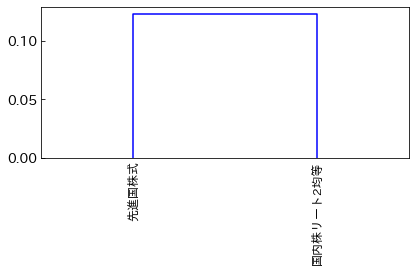

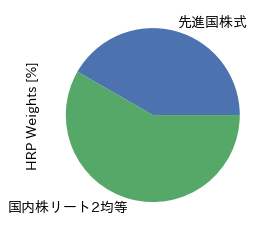

In [ ]:
from pypfopt.hierarchical_portfolio import HRPOpt
from pypfopt import plotting
hrp = HRPOpt(PickDataDF.loc[:,OptimizationList])
WeightsHRP = hrp.optimize()
CleanedWeightsHRP = hrp.clean_weights()
WeightsHRP_DF = pd.DataFrame(CleanedWeightsHRP,index=["HRP Weights [%]"])*100
plotting.plot_dendrogram(hrp)
display(WeightsHRP_DF.T)
# WeightsHRP_DF.to_clipboard()
# hrp.portfolio_performance(verbose=True,risk_free_rate=RiskFreeRate)
piePlot = WeightsHRP_DF.T.plot.pie(figsize=(12,4), subplots=True, legend=False)